# Reconocimiento facial: python + tensorflow + keras

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
DIR_KNOWNS = 'knowns'
DIR_UNKNOWNS = 'unknowns'
DIR_RESULTS = 'results'

In [3]:
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

In [4]:
print(mobilenet)

In [5]:
# Cargar imagen
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

In [7]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [8]:
# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

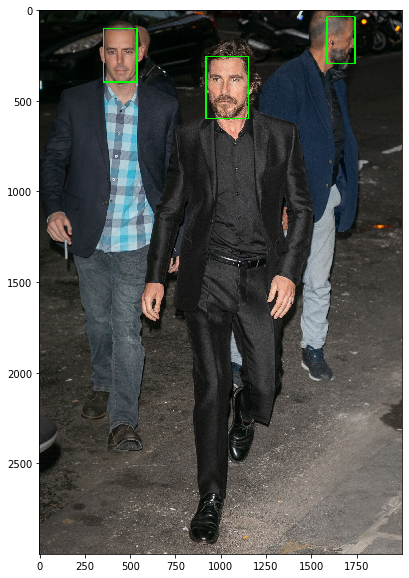

In [11]:
name = 'christian_bale_01.jpg'
image = load_image(DIR_UNKNOWNS,name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [14]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

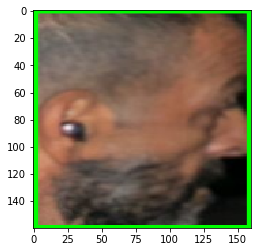

In [18]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[2])

In [19]:
# FaceNet
facenet = load_model('facenet_keras.h5')
print(facenet.input_shape)
print(facenet.output_shape)

(None, 160, 160, 3)
(None, 128)


In [20]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [21]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[-4.26647753e-01 -6.41013622e-01 -2.31208354e-01 -4.84840944e-02
  -1.18542290e+00  6.22719169e-01  8.59655559e-01 -1.36113837e-01
  -3.05095345e-01 -5.40957093e-01  1.38940156e+00 -1.73634934e+00
   1.20331556e-01 -7.43273973e-01 -8.80437255e-01  4.83072340e-01
  -1.64128751e-01 -1.42947769e+00 -1.41717303e+00 -2.97024757e-01
   6.54603362e-01  1.38104296e+00  4.55870986e-01  8.94368947e-01
  -6.26556039e-01 -2.65926182e-01  9.29332733e-01 -1.93000925e+00
   6.46763146e-01  1.80726960e-01 -6.88571334e-01  6.32463753e-01
   1.22548342e+00 -3.41159165e-01  1.19012344e+00  5.02296269e-01
   8.42343986e-01  1.84032238e+00  6.60475314e-01  8.45298529e-01
   2.33549759e-01  5.60377181e-01 -2.93602705e-01 -1.22998762e+00
  -2.54769862e-01 -2.92127430e-01  1.54830384e+00  5.01721025e-01
  -6.65640235e-01  5.69216967e-01 -6.68590248e-01 -3.59147787e-01
   5.50906003e-01 -4.02338505e-01  2.43037522e-01  7.39932477e-01
  -6.98154986e-01  4.04463679e-01  6.82466507e-01 -7.65415490e-01
   1.40775

In [24]:
# Embeddings referencia
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir(DIR_KNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_KNOWNS,name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0]))        
        
        
        

Procesando rostros conocidos...
   miguel_04.jpg
   miguel_01.jpg
   miguel_02.jpg
   miguel_03.jpg


In [25]:
print(known_embeddings)

[array([[-9.1378868e-01, -2.6313365e-01,  5.4767823e-01,  7.5353688e-01,
         1.3428286e+00,  1.5418046e+00,  4.0147433e-01, -4.2143375e-01,
         9.0606040e-01,  5.1455658e-02,  2.0961361e+00, -9.7437453e-01,
        -1.2613459e-01, -1.2800219e+00, -1.7614579e-01,  1.6038574e+00,
        -8.5523891e-01, -4.3377876e-01, -1.9184752e+00,  8.7599272e-01,
         6.0277653e-01, -8.8823730e-01, -3.1376165e-01, -5.4579221e-02,
        -6.5078175e-01,  8.0788714e-01, -1.4630951e-01,  1.7349375e+00,
        -8.7041473e-01, -4.7856271e-01,  1.2072058e+00, -7.3054439e-01,
        -2.1194968e-01, -9.4489771e-01, -7.1937507e-01, -1.0441798e+00,
        -5.2469772e-01, -1.1192515e+00,  1.0418415e+00,  8.5215437e-01,
        -7.6363474e-02, -1.5954443e+00,  4.1442418e-01, -1.3658754e+00,
         8.2793152e-01, -1.3238878e+00, -7.4736685e-01,  1.8798712e+00,
         1.2017195e+00, -1.6424249e+00,  1.2635165e+00,  3.3651999e-01,
        -4.4915971e-01,  9.8933601e-01,  2.4714278e-01, -1.6771

In [26]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [29]:
# Reconocimiento (????) de rostros desconocidos
print('Procesando imágenes desconocidas...')
for name in os.listdir(DIR_UNKNOWNS):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image(DIR_UNKNOWNS,name)
        bboxes = detect_faces(image)
        faces = extract_faces(image,bboxes)
        
        # Por cada rostro calcular embedding
        img_with_boxes = image.copy()
        for face, box in zip(faces,bboxes):
            emb = compute_embedding(facenet,face)
            
            _, reconocimiento = compare_faces(known_embeddings,emb)
            
            if any(reconocimiento):
                print('     match!')
                img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
            else:
                img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
            
        cv2.imwrite(f'{DIR_RESULTS}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
print('¡Fin!')                    
            
        
        
        

Procesando imágenes desconocidas...
   christian_bale_01.jpg
   christian_bale_03.jpg
   christian_bale_02.jpg
   miguel_08.jpg
     match!
   miguel_09.jpg
     match!
   jerry_seinfeld_03.jpg
   miguel_07.jpg
     match!
   miguel_06.jpg
     match!
   jerry_seinfeld_02.jpg
   jack_nicholson_01.jpg
   jack_nicholson_03.jpg
   miguel_10.jpg
     match!
   miguel_05.jpg
     match!
   jerry_seinfeld_01.jpg
   jack_nicholson_02.jpg
¡Fin!
